In [61]:
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from scipy import integrate, optimize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.dates as mdates
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [62]:
# from IPython.display import HTML
# HTML('''<script>
#   function code_toggle() {
#     if (code_shown){
#       $('div.input').hide('500');
#       $('#toggleButton').val('Show Code')
#     } else {
#       $('div.input').show('500');
#       $('#toggleButton').val('Hide Code')
#     }
#     code_shown = !code_shown
#   }
#   $( document ).ready(function(){
#     code_shown=false;
#     $('div.input').hide()
#   });
# </script>
# <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Reading the dataset


Datasets 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data'

In [63]:
#DATASET CONTAINING INFORMATION OF POPULATION DENSITY , AVG. TEMPERATURE , RELATIVE HUMIDITY
geo_data = pd.read_csv('place_list_2k.csv', encoding = "ISO-8859-1")
geo_data = geo_data.set_index(['Unnamed: 0'])
geo_data_train = geo_data.iloc[:89,:]
geo_data_test = geo_data.iloc[89:]


In [64]:
#READING COVID19 confirmed, death and recovery dataset 
covid_cnf_ts = pd.read_csv('time_series_covid19_confirmed_global.csv')
covid_de_ts = pd.read_csv('time_series_covid19_deaths_global.csv')
covid_re_ts = pd.read_csv('time_series_covid19_recovered_global.csv')

In [65]:
plt.style.use('fivethirtyeight')

In [66]:
date_columns = list(covid_cnf_ts.iloc[:,4:].columns)
covid_cnf_ts = covid_cnf_ts[covid_cnf_ts['Country/Region'] != 'Cruise Ship']
covid_de_ts = covid_de_ts[covid_de_ts['Country/Region'] != 'Cruise Ship']
covid_re_ts = covid_re_ts[covid_re_ts['Country/Region'] != 'Cruise Ship']

# covid_cnf_ts_grouped = covid_cnf_ts.groupby('Country/Region')[date_columns].sum()
# covid_de_ts_grouped = covid_de_ts.groupby('Country/Region')[date_columns].sum()
# covid_re_ts_grouped = covid_re_ts.groupby('Country/Region')[date_columns].sum()

Selecting places/regions where confirmed cases till date is greater than 100

In [67]:
covid_details = pd.concat([covid_cnf_ts.iloc[:,-1],covid_re_ts.iloc[:,-1], covid_de_ts.iloc[:,-1]], axis = 1 )
covid_details.columns =['Confirmed', 'Recovery', 'Death']
covid_details = covid_details[(covid_details['Confirmed'] > 100) & (covid_details['Recovery'] > 10) & (covid_details['Death']>0)]


In [68]:
covid_cnf_aggregate = covid_cnf_ts.iloc[:,4:].T.sum()
covid_cnf_ts['Total'] = covid_cnf_aggregate
sort_cnf = covid_cnf_ts.sort_values(by = ['Total'], ascending = False)
sort_cnf
affected_countries_confirmed = covid_cnf_ts
affected_countries_confirmed = affected_countries_confirmed.ix[sort_cnf.index]
affected_countries_confirmed = affected_countries_confirmed[affected_countries_confirmed.iloc[:,-2]>100]

covid_de_aggregate = covid_de_ts.iloc[:,4:].T.sum()
covid_de_ts['Total'] = covid_de_aggregate
sort_de = covid_de_ts.sort_values(by = ['Total'], ascending = False)
affected_countries_death = covid_de_ts
affected_countries_death = affected_countries_death.ix[sort_de.index]
affected_countries_death = covid_de_ts[covid_de_ts.iloc[:,-2]> 1]

covid_re_aggregate = covid_re_ts.iloc[:,4:].T.sum()
covid_re_ts['Total'] = covid_re_aggregate
sort_re = covid_re_ts.sort_values(by = ['Total'], ascending = False)
affected_countries_recovery = covid_re_ts
affected_countries_recovery = affected_countries_recovery.ix[sort_re.index]
affected_countries_recovery = covid_re_ts[covid_re_ts.iloc[:,-2] > 10]


We are not considering dataset of China because of large discreapancies in dataset. We are not considering India, as it is the country of our interest (to avoid overfitting).

In [69]:
confirmed_cases_df = affected_countries_confirmed[(affected_countries_confirmed['Country/Region'] != 'China') &  
                                                  (affected_countries_confirmed['Country/Region']!= 'India')]
country_details = confirmed_cases_df.iloc[:,:4]
# country_details.to_csv('place_list_1.csv')

Assumption - 1 : Susceptible population is 100 times more than total number of infected till date.

In [70]:
confirmed_cases_df['Total'] = 100*confirmed_cases_df.iloc[:,-2]


In [71]:
#SIR MODEL 
def SIR_model(SIR_info, time, beta, gamma):
    '''Fits SIR model into data and returns effective contact rate (beta)
    and recovery rate (gamma).'''
    
    S = SIR_info[0]
    I= SIR_info[1]
    R = SIR_info[2]
    
    St = - beta*S*I/population
    Rt = gamma*I
    It = -(St+Rt)
    return St, It, Rt

def ode_solution(time, beta, gamma):
    '''Solves SIR Differential equations'''
    return integrate.odeint(SIR_model, (initial_susceptible, initial_infected, initial_recovered),
                            time,args=(beta, gamma))[:,1]


#Early epidemic growth model Chowell, 2016

def chowell_model(C, time, r,p):
    dC_Dt = r*(C)**p
    
    return dC_Dt

def integrate_chowell_model(time, r, p):
    return integrate.odeint(chowell_model, initial_infected,
                            time,args=(r, p))

def chowell_model_solution(time, r,p):
#     print('r',r,'p',p)
    m = 1/(1-p)
    A = initial_infected**(1/m)
    C = ((r/m)*time + A)**m
    return C


'-------------------------'

def covid_likelihood(params, *data):
    '''Constructs a likelihood based on the data observed'''
    
    k = params[0]
    b= params[1]
    sd = params[2]
    y_dat = data
    f = 1/(1+np.exp(-k*(x_dat-b)))
#     print(stats.norm.logpdf(y_dat, f, sd))
    likelihood = - np.sum(stats.norm.logpdf(y_dat/y_dat[-1], f, sd))
    return likelihood

def sigmoid(x,a,b,c):
    '''Non scaled sigmoid function to model the data'''
    c = 1
    f = c/(1+np.exp(-(x-b)/a))
    return f

def sigmoid_1(x,a,b):
    '''Scaled sigmoid function to model the normalized data'''
    f = 1/(1+np.exp(-(x-b)/a))
    return f

def get_param_estimate(function, initparams):
    estimates = minimize(covid_likelihood, [1,1,1], method = 'Nelder-Mead')
    return estimates.x

def func_exp(x, a,b, c):
    c = 0
    return a * np.exp(b * x) + c

def parameter_estimations(x, y, scale_flag):
    '''Provides functionality for parameter estimations 
    with or without scaling (provided by scale_flag)'''
    if scale_flag:
        y_scale = y/y[-1]
        p0 = [2, np.argmax(y)]
        popt, pcov = curve_fit(sigmoid_1, x, y_scale, p0, method='dogbox',maxfev=100000)
        parameter = [popt[0], popt[1]]
    else:
        p0 = [2, np.argmax(y_dat), np.max(y)]
        popt, pcov = curve_fit(func_exp, x, y, p0 , maxfev = 10000)
        parameter = [popt[0], popt[1], popt[2]]
    return parameter

Identifying time point first infection case for each place 

In [72]:
first_non_zero_location = confirmed_cases_df.iloc[:,4:-1].T.ne(0).idxmax()
column_info = pd.Series(confirmed_cases_df.columns)
#storing the index of the dates 
index_dict = {}
for i in column_info:
    loc = column_info[column_info == i].index.tolist()
    index_dict[i] = loc

In [73]:

chowell_model = False
parameter_list = []
for place in range(len(confirmed_cases_df)):
    population = confirmed_cases_df.iloc[place, -1]
    first_non_zero_date = confirmed_cases_df.iloc[place,4:-1].T.ne(0).idxmax()
    non_zero_index = index_dict[first_non_zero_date][0]
    initial_infected = confirmed_cases_df.iloc[place, non_zero_index]
#     print('initial_infected',initial_infected, non_zero_index)
    initial_susceptible = population - initial_infected
    initial_recovered = 0 
    xdata = np.arange(0,len(confirmed_cases_df.iloc[place,non_zero_index:-1]))
#     print(xdata)
    ydata = confirmed_cases_df.iloc[place,non_zero_index:-1]
#     print(ydata.values.tolist())
    if chowell_model:
        param_bounds=(0,[10,1])
        popt, pcov = optimize.curve_fit(chowell_model_solution, xdata,
                                        ydata.values.tolist(),bounds= param_bounds,method='dogbox',maxfev=100000)
    else:
        param_bounds=(0,[np.inf,np.inf])
        popt, pcov = optimize.curve_fit(ode_solution, xdata,
                                        ydata.values.tolist(),bounds= param_bounds,method='dogbox',maxfev=1000)
    parameter_list.append(popt)
    
    

In [74]:
beta = [i[0] for i in parameter_list]
gamma = [i[1] for i in parameter_list]

In [75]:
confirmed_cases_df['beta'] = beta
confirmed_cases_df['gamma'] = gamma
confirmed_cases_df['pop_density'] = geo_data_train['Pop Density']

In [76]:
geo_data_train.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Pop', 'Pop Density',
       'Avg Temp Feb (in _)', 'Avg Temp Mar (in _)',
       'Relative Humidity Feb (in %)', 'Relative Humidity Mar (in %)'],
      dtype='object')

In [77]:
avg_temp = (geo_data_train['Avg Temp Mar (in _)'] + geo_data_train['Avg Temp Feb (in _)'])/2
confirmed_cases_df['average_tem'] = avg_temp
confirmed_cases_df['RH'] = (geo_data_train['Relative Humidity Feb (in %)'] + geo_data_train['Relative Humidity Mar (in %)'])/2

In [78]:
confirmed_cases_df_1 = confirmed_cases_df[confirmed_cases_df.iloc[:,-6]>100]

In [79]:
confirmed_cases_df_1 = confirmed_cases_df_1[confirmed_cases_df_1['average_tem'].notnull()]

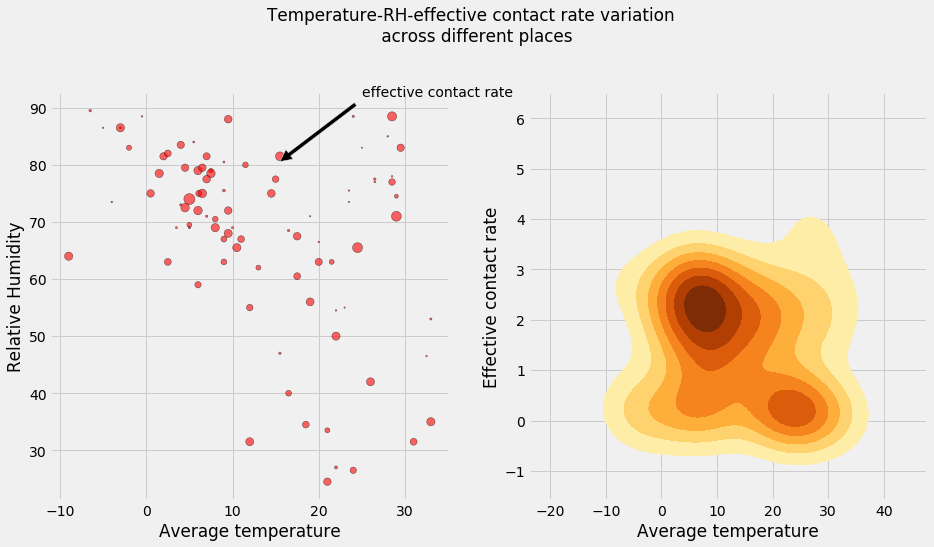

In [80]:
fig = plt.figure(figsize = (14, 7))
fig.add_subplot(1,2,1)
plt.scatter(x = confirmed_cases_df_1['average_tem'], 
            y = confirmed_cases_df_1['RH'], 
            s = confirmed_cases_df_1['beta']*25, 
            alpha=0.6, c ='red',
            edgecolors='black')
plt.annotate('effective contact rate', xy=(15, 80), xytext=(25, 92),
                   arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('Average temperature')
plt.ylabel('Relative Humidity')
sns.kdeplot(confirmed_cases_df_1['average_tem'], (confirmed_cases_df_1['beta']) ,cmap="YlOrBr", kind="kde", shade=True, shade_lowest=False, ax =fig.add_subplot(1,2,2)) 
plt.xlabel('Average temperature')
plt.ylabel('Effective contact rate')
plt.suptitle('Temperature-RH-effective contact rate variation \n across different places', y=1.05)
plt.savefig('Figure_1.png')
plt.show()

We chose a non parametric regression for estimating effective contact and recovery rates. Nearest neighbour usuallybecomes a good choice in low dimension but suffers considerably from curse of dimensionality. Hence we chose Locality Sensitive Hashing Forest (LSHForest) as our model for estimation.

In [81]:
from sklearn.neighbors import LSHForest
import numpy as np
from scipy.stats import mode

class LSH_KNN:

    def __init__(self, **kwargs):
        self.n_neighbors = kwargs['n_neighbors']
        self.lsh = LSHForest(**kwargs)

    def fit(self, X, y):
        self.y = y
        self.lsh.fit(X)

    def predict(self, X):
        _, indices = self.lsh.kneighbors(X, n_neighbors = self.n_neighbors)
#         print(indices, len(indices))
        beta_list = []
        for i in range(len(indices)):
            beta_neighbour = []
            for j in indices[i]:
                beta = self.y[j]
                beta_neighbour.append(beta)
                beta_m = np.mean(beta_neighbour)
            beta_list.append(beta_m)
        return beta_list

In [82]:
modeling_data = pd.concat([confirmed_cases_df['average_tem'][:70], confirmed_cases_df['RH'], confirmed_cases_df['beta'], confirmed_cases_df['gamma']], axis = 1)
modeling_data = modeling_data.dropna()
x = modeling_data.iloc[:,:2]
beta = modeling_data['beta'].values
gamma = modeling_data['gamma'].values
x_train, x_test, y_train, y_test = train_test_split(x,beta, test_size = 0.01, random_state = 42)
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
# x_test_sc = sc.fit_transform(x_test)

In [83]:
state_list = geo_data_test['Province/State'].values.tolist()

In [97]:
RH = (geo_data_test['Relative Humidity Feb (in %)'] + geo_data_test['Relative Humidity Mar (in %)'])/2
Temp = (geo_data_test['Avg Temp Feb (in _)'] + geo_data_test['Avg Temp Mar (in _)'])/2
test_df = pd.DataFrame(list(zip(RH.values.tolist(), Temp.values.tolist())))
test_df.index = state_list
test_df.columns = ['RH', 'Temp']

In [98]:
test_df

,RH,Temp
Maharashtra,72.0,28.5
West Bengal,70.5,28.5
Kerala,73.0,30.0
Rajasthan,45.5,25.0
Karnataka,55.0,26.5


In [99]:
test_df['RH_Apr-May'] = [74, 77, 75,25,53]
test_df['Temp_Apr_May'] = [31,31,30,33,30]

In [100]:
test_df

,RH,Temp,RH_Apr-May,Temp_Apr_May
Maharashtra,72.0,28.5,74,31
West Bengal,70.5,28.5,77,31
Kerala,73.0,30.0,75,30
Rajasthan,45.5,25.0,25,33
Karnataka,55.0,26.5,53,30


In [102]:
x_test_1 = sc.fit_transform(test_df.iloc[:,:2])
x_test_sc = x_test_1
x_test_sc_1 = sc.fit_transform(test_df.iloc[:,2:])
model = LSH_KNN(n_neighbors = 7)
fit = model.fit(x_train_sc,beta)
beta_pred_Feb_Mar = model.predict(x_test_sc)
beta_pred_Apr_May = model.predict(x_test_sc_1)


fit_1 = model.fit(x_train, gamma )
gamma_pred_Feb_Mar = model.predict(x_test_sc)
gamma_pred_Apr_May = model.predict(x_test_sc_1)

test_df['beta_1']= beta_pred_Feb_Mar
test_df['gamma_1'] = gamma_pred_Feb_Mar

test_df['beta_2']= beta_pred_Apr_May
test_df['gamma_2'] = gamma_pred_Apr_May


Scaling beta and gamma 

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
beta_extend = np.append(beta, np.array(beta_pred_Feb_Mar))
beta_extend_1 = np.append(beta_extend, beta_pred_Apr_May)
beta_transform = scaler.fit_transform(beta_extend_1.reshape((-1,1)))*100

gamma_extend = np.append(gamma, np.array(gamma_pred_Feb_Mar))
gamma_extend_1 = np.append(gamma_extend, np.array(gamma_pred_Apr_May))
gamma_transform = scaler.fit_transform(gamma_extend_1.reshape((-1,1)))*100


In [106]:
beta_india = [i[0] for i in beta_transform[-10:]]
gamma_india = [i[0] for i in gamma_transform[-10:]]
abm_input_FM = pd.DataFrame(list(zip(beta_india[:5], gamma_india[:5])))
abm_input_AM = pd.DataFrame(list(zip(beta_india[5:], gamma_india[5:])))
abm_input_FM.columns = ['Contact %', 'Recovery %']
abm_input_FM.index = state_list

abm_input_AM.columns = ['Contact%', 'Recovery %']
abm_input_AM.index = state_list


In [109]:
#ABM Input for Feb-March
abm_input_FM

,Contact %,Recovery %
Maharashtra,34.589683,32.404545
West Bengal,42.935099,32.404545
Kerala,35.012372,40.454810
Rajasthan,26.370615,17.775079
Karnataka,26.370615,17.775079


In [110]:
#ABM Input for April-May
abm_input_AM

,Contact%,Recovery %
Maharashtra,27.014044,32.404545
West Bengal,27.014044,32.404545
Kerala,37.057217,28.552266
Rajasthan,27.214620,24.321619
Karnataka,25.103035,17.775079


In [111]:
date_rng = pd.date_range(start='3/14/2020', end='5/14/2020', freq='D')
df_1 = pd.read_csv('wb_lockdown.csv',error_bad_lines=False)
df_2 = pd.read_csv('wb_no_lockdown.csv',error_bad_lines=False)
df_1.index = date_rng
df_2.index = date_rng


date_rng_1 = pd.date_range(start='3/01/2020', end='5/01/2020', freq='D')
df_3 = pd.read_csv('kerala_lockdown.csv',error_bad_lines=False)
df_4 = pd.read_csv('kerala_no_lockdown.csv',error_bad_lines=False)
df_3[:len(date_rng_1)].index = date_rng_1
df_4[:len(date_rng_1)].index = date_rng_1

df_5 = pd.read_csv('karnataka_lockdown.csv',error_bad_lines=False)
df_6 = pd.read_csv('karnataka_no_lockdown.csv',error_bad_lines=False)
df_6 = df_6[:len(date_rng_1)]
df_5.index = date_rng_1
df_6.index = date_rng_1

df_7 = pd.read_csv('rajasthan_lockdown.csv',error_bad_lines=False)
df_8 = pd.read_csv('rajasthan_no_lockdown.csv',error_bad_lines=False)
df_7 = df_7[:len(date_rng_1)]
df_8 = df_8[:len(date_rng_1)]
df_7.index = date_rng_1
df_8.index = date_rng_1

date_rng_3 = pd.date_range(start='3/09/2020', end='5/09/2020', freq='D')

df_9 = pd.read_csv('maharashtra_lockdown.csv',error_bad_lines=False)
df_10 = pd.read_csv('maharashtra_no_lockdown.csv',error_bad_lines=False)
df_9 = df_9[:len(date_rng_3)]
df_10 = df_10[:len(date_rng_3)]
df_9.index = date_rng_3
df_10.index = date_rng_3

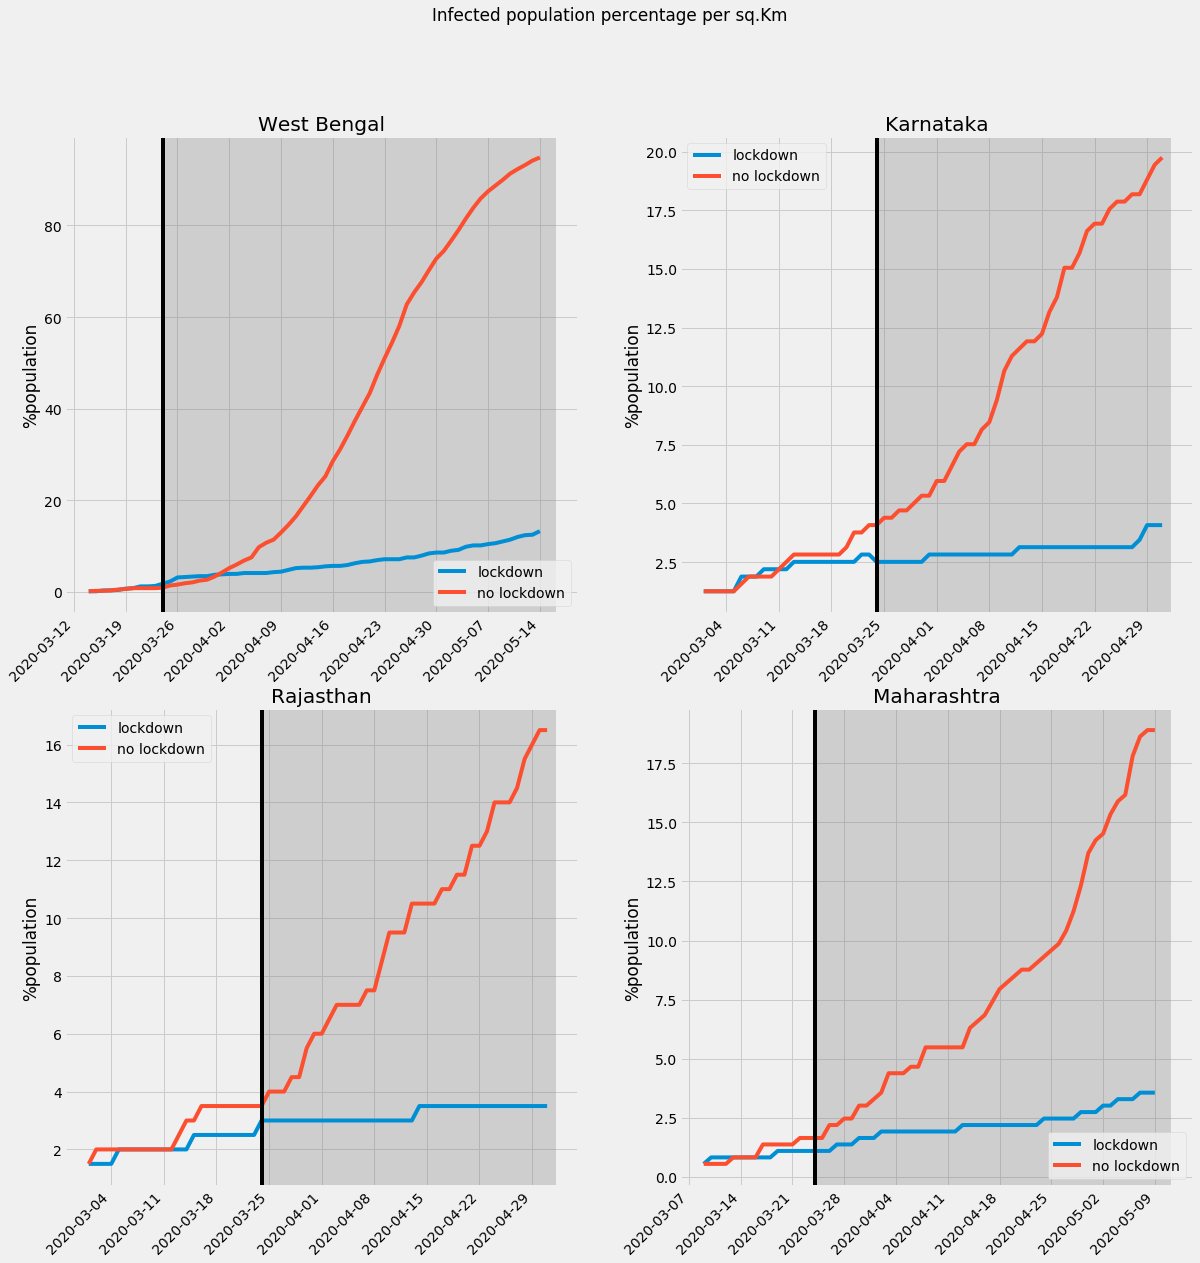

In [112]:
plt.figure(figsize = (18,18))
plt.subplot(2,2,1)
plt.plot(df_1['y'][:]*100/1028, label = 'lockdown')
plt.plot(df_2['y'][:]*100/1028, label = 'no lockdown')
plt.xticks(rotation=45, ha="right")
plt.ylabel('%population')
plt.axvline(dt.datetime(2020, 3, 24), c ='black')
x = dt.datetime(2020, 3, 24)
x1 = dt.datetime(2020, 5, 16)
plt.axvspan(x, x1, alpha=0.3, color='grey')
plt.legend()
plt.title( 'West Bengal')

plt.subplot(2,2,2)
plt.plot(df_5['y']*100/319, label = 'lockdown')
plt.plot(df_6['y']*100/319, label = 'no lockdown')
plt.xticks(rotation=45, ha="right")
plt.ylabel('%population')
plt.axvline(dt.datetime(2020, 3, 24), c ='black')
x = dt.datetime(2020, 3, 24)
x1 = dt.datetime(2020, 5, 2)
plt.axvspan(x, x1, alpha=0.3, color='grey')
plt.legend()
plt.title( 'Karnataka')



plt.subplot(2,2,3)
plt.plot(df_7['y']*100/200, label = 'lockdown')
plt.plot(df_8['y']*100/200, label = 'no lockdown')
plt.xticks(rotation=45, ha="right")
plt.ylabel('%population')
plt.axvline(dt.datetime(2020, 3, 24), c ='black')
x = dt.datetime(2020, 3, 24)
x1 = dt.datetime(2020, 5, 2)
plt.axvspan(x, x1, alpha=0.3, color='grey')
plt.legend()
plt.title( 'Rajasthan')



plt.subplot(2,2,4)
plt.plot(df_9['y']*100/365, label = 'lockdown')
plt.plot(df_10['y']*100/365, label = 'no lockdown')
plt.xticks(rotation=45, ha="right")
plt.ylabel('%population')
plt.axvline(dt.datetime(2020, 3, 24), c ='black')
x = dt.datetime(2020, 3, 24)
x1 = dt.datetime(2020, 5,11)
plt.axvspan(x, x1, alpha=0.3, color='grey')
plt.legend()
plt.title( 'Maharashtra')

plt.suptitle('Infected population percentage per sq.Km')
# plt.savefig('Figure_2.png')
plt.show()



# plt.annotate('effective contact rate', xy=(11, 12), xytext=(11, 12),
#                    arrowprops=dict(facecolor='black', shrink=0.05))

In [117]:
#Number of days(d) between first COVID infection and lockdown announcement  
#infected_population_lockdown_state = df_1['y'][d]/population density
infected_population_lockdown_wb = df_1['y'][4]/1028
infected_population_lockdown_karnataka = df_5['y'][24]/319
infected_population_lockdown_rajasthan = df_9['y'][24]/200
infected_population_lockdown_maharastra = df_9['y'][15]/365

In [118]:
print('infected population  percentage per sq.km till lockdown West Bengal :', round(infected_population_lockdown_wb,3)*100)
print('infected population  percentage per sq.km till lockdown Karnataka :', round(infected_population_lockdown_karnataka,2)*100)

print('infected population  percentage per sq.km till lockdown Rajasthan :', round(infected_population_lockdown_rajasthan,2)*100)

print('infected population  percentage per sq.km till lockdown Maharashtra :', round(infected_population_lockdown_maharastra,2)*100)



infected population  percentage per sq.km till lockdown West Bengal : 0.4
infected population  percentage per sq.km till lockdown Karnataka : 3.0
infected population  percentage per sq.km till lockdown Rajasthan : 4.0
infected population  percentage per sq.km till lockdown Maharashtra : 1.0
